In [1]:
import numpy as np
import rydiqule as rq
import matplotlib.pyplot as plt
import numba as nb

In [2]:
rq.about()


        Rydiqule
    
Rydiqule Version:     1.3.0.dev459+gf957ae8.d20241203
Installation Path:    ~\src\rydiqule\src\rydiqule

      Dependencies
    
NumPy Version:        1.26.4
SciPy Version:        1.10.1
Matplotlib Version:   3.7.1
ARC Version:          3.6.0
Python Version:       3.11.5
Python Install Path:  ~\miniconda3\envs\rq
Platform Info:        Windows (AMD64)
CPU Count and Freq:   16 @ 3.91 GHz
Total System Memory:  256 GB


In [3]:
%load_ext line_profiler

In [4]:
%load_ext autoreload
%autoreload 2

In [18]:
s_time = rq.Sensor(4)
s_ss = rq.Sensor(4)

vP = 1 # m/s, unphysical, but improves doppler solve times

red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*0.6, 'detuning':0,
            'kvec':2*np.pi/780e-3*vP*np.array([1,0,0])}
blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*1.0, 'detuning':0,
             'kvec':2*np.pi/480e-3*vP*np.array([-1,0,0])}

s_time.add_decoherence((1,0), 2*np.pi*6)
s_time.add_decoherence((2,1), 2*np.pi*0.01)
s_time.add_decoherence((3,0), 2*np.pi*0.005)
s_time.add_decoherence((3,2), 2*np.pi*0.005)
s_time.add_transit_broadening(2*np.pi*1)

s_ss.add_decoherence((1,0), 2*np.pi*6)
s_ss.add_decoherence((2,1), 2*np.pi*0.01)
s_ss.add_decoherence((3,0), 2*np.pi*0.005)
s_ss.add_decoherence((3,2), 2*np.pi*0.005)
s_ss.add_transit_broadening(2*np.pi*1)


rf_freq = 658.587 # MHz
rf_rabi = 25
local_oscillator_ss = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0}

s_ss.add_couplings(red_laser, blue_laser, local_oscillator_ss)
s_time.add_couplings(red_laser, blue_laser)

## Non-RWA Solves ##

In [13]:
def sig_and_LO(omega_0, delta, beta):
    def fun(t):
        return np.sin(omega_0*t)+beta*np.sin((omega_0+delta)*t)
    return fun

In [7]:
omega_0 = 2*np.pi*rf_freq
delta = 5 
beta = 0.05

In [8]:
@nb.njit("f8(f8)", cache=True)
def non_rwa_sig_and_LO(t):
    return np.sin(omega_0*t)+beta*np.sin((omega_0+delta)*t)

### Using a pure-python time function ###

In [9]:
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'time_dependence': sig_and_LO(omega_0, delta, beta ), 'transition_frequency':2*np.pi*rf_freq}
s_time.add_couplings(rf_transition)

In [10]:
sol_init = rq.solve_steady_state(s_ss)

In [11]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(s_time, end_time, sample_num, init_cond=sol_init.rho)

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 8.92 s
Wall time: 8.93 s


In [12]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(s_time, end_time, sample_num, init_cond=sol_init.rho,
                             eqns='comp')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 17.2 s
Wall time: 17.2 s


Note that this cell runs at about 3.7s when run the 2nd time. Suspect numba caching helping.

In [13]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(s_time, end_time, sample_num, init_cond=sol_init.rho,
                             solver='cyrk')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 6.3 s
Wall time: 6.45 s


In [14]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(s_time, end_time, sample_num, init_cond=sol_init.rho,
                             solver='cyrk', eqns='flat')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 4.7 s
Wall time: 4.77 s


### Using a pre-jitted time function ###

In [15]:
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'time_dependence': non_rwa_sig_and_LO, 'transition_frequency':2*np.pi*rf_freq}
s_time.add_couplings(rf_transition)

In [16]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(s_time, end_time, sample_num, init_cond=sol_init.rho)

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 8.36 s
Wall time: 8.36 s


In [17]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(s_time, end_time, sample_num, init_cond=sol_init.rho,
                             eqns='comp')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 15.1 s
Wall time: 15.1 s


In [18]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(s_time, end_time, sample_num, init_cond=sol_init.rho,
                             solver='cyrk')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 5.92 s
Wall time: 6 s


In [22]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(s_time, end_time, sample_num, init_cond=sol_init.rho,
                             solver='cyrk', eqns='flat')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 4.58 s
Wall time: 4.64 s


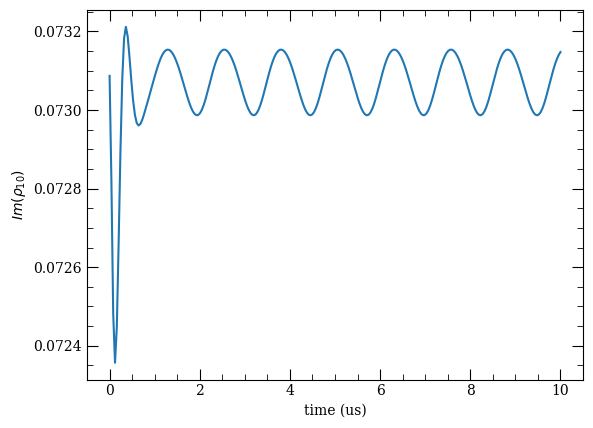

In [20]:
fig, ax = plt.subplots()
ax.plot(time_sol_beat.t, time_sol_beat.rho_ij(1,0).imag)
ax.set_xlabel("time (us)");
ax.set_ylabel('$Im(\\rho_{10})$');
ylims = ax.get_ylim()

## RWA solves ##

In [9]:
def sig_LO_RWA(det, beta):
    def fun(t):
        return 1+beta*np.exp(1j*det*t)
    return fun

In [10]:
@nb.njit("c16(f8)", cache=True)
def rwa_sig_and_LO(t):
    return 1+beta*np.exp(1j*delta*t)

In [11]:
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0, 'time_dependence': sig_LO_RWA(delta, beta)}
s_time.add_couplings(rf_transition)

In [26]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num)

CPU times: total: 31.2 ms
Wall time: 43.4 ms


In [27]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num, eqns='comp')

CPU times: total: 46.9 ms
Wall time: 56.1 ms


In [28]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num, solver='cyrk')

CPU times: total: 469 ms
Wall time: 533 ms


In [29]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num, solver='cyrk', eqns='flat')

CPU times: total: 266 ms
Wall time: 334 ms


In [30]:
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0, 'time_dependence': rwa_sig_and_LO}
s_time.add_couplings(rf_transition)

In [31]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num)

CPU times: total: 31.2 ms
Wall time: 31.3 ms


In [32]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num, eqns='comp')

CPU times: total: 62.5 ms
Wall time: 53.3 ms


In [33]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num, solver='cyrk')

CPU times: total: 453 ms
Wall time: 505 ms


In [34]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num, solver='cyrk', eqns='flat')

CPU times: total: 344 ms
Wall time: 417 ms


(0.07231381830164374, 0.07325454870829601)

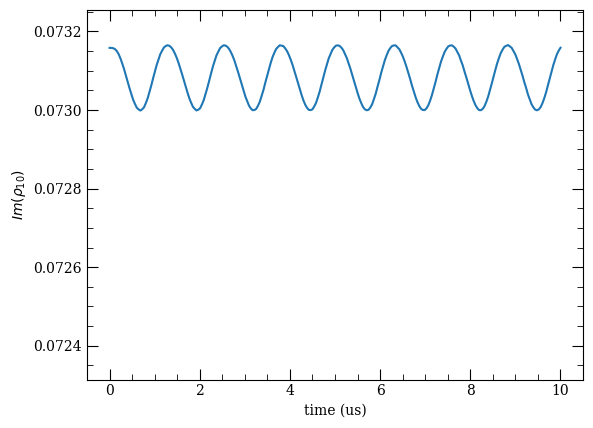

In [35]:
fig, ax = plt.subplots()
ax.plot(time_sol_beat.t, time_sol_beat.rho_ij(1,0).imag)
ax.set_xlabel("time (us)");
ax.set_ylabel('$Im(\\rho_{10})$');
ax.set_ylim(*ylims)

## Doppler RWA solves ##

In [19]:
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0,
                 'time_dependence': sig_LO_RWA(delta, beta)}
s_time.add_couplings(rf_transition)

In [20]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num,
                             doppler=True)

CPU times: total: 4.03 s
Wall time: 503 ms


In [21]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num,
                             doppler=True, eqns='comp')

CPU times: total: 3.89 s
Wall time: 503 ms


In [22]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num,
                             doppler=True, solver='cyrk')

CPU times: total: 2.88 s
Wall time: 1.36 s


In [23]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num,
                             doppler=True, solver='cyrk', eqns='flat')

RydiquleError: CyRK flat solver incompatible with doppler solves

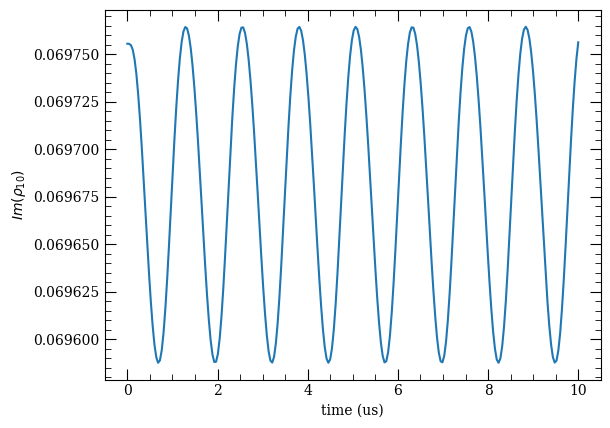

In [24]:
fig, ax = plt.subplots()
ax.plot(time_sol_beat.t, time_sol_beat.rho_ij(1,0).imag)
ax.set_xlabel("time (us)");
ax.set_ylabel('$Im(\\rho_{10})$');

## Large Doppler RWA solves ##

In [25]:
rf_detunings = np.linspace(0, 20, 101)
rf_transition_det = {'states':(2,3), 'rabi_frequency':rf_rabi,
                 'detuning':2*np.pi*rf_detunings,
                 'time_dependence': sig_LO_RWA(delta, beta)}
s_time.add_couplings(rf_transition_det)

In [26]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num,
                             doppler=True)

CPU times: total: 43min 8s
Wall time: 5min 36s


In [27]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num,
                             doppler=True, eqns='comp')

CPU times: total: 40min 47s
Wall time: 5min 10s


In [28]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num,
                             doppler=True, solver='cyrk')

CPU times: total: 5min 12s
Wall time: 5min 9s


In [29]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(s_time, end_time, sample_num,
                             doppler=True, solver='cyrk',
                             n_slices=20)

Breaking equations of motion into 20 sets of equations...
CPU times: total: 3min 38s20
Wall time: 3min 10s


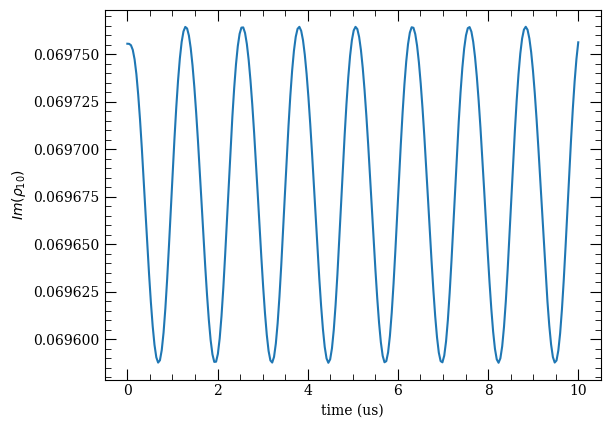

In [30]:
fig, ax = plt.subplots()
ax.plot(time_sol_beat.t, time_sol_beat.rho_ij(1,0).imag[0])
ax.set_xlabel("time (us)");
ax.set_ylabel('$Im(\\rho_{10})$');
#ax.set_ylim(bottom = .586, top = .589)